In [1]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, det_curve
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from torch import Tensor
from collections import defaultdict
import numpy as np
import time
from representation_model import PENetwork, CompositeClassifierFromRepresentations
ROOT = "../../"
import sys
sys.path.append(ROOT)
from utils.functions import sigmoid, fix_random_seed
from models import Filepath, Emulation

SEED = 42
fix_random_seed(SEED)

#dataset_folder = "/data/quo.vadis/evaluation/representations/set_cropped_20/"
dataset_folder = "/data/quo.vadis/evaluation/representations/set_full/"

X_train = np.load(open(dataset_folder + "Xtrain.npy", "rb"))
y_train = np.load(open(dataset_folder + "ytrain.npy", "rb"))
X_val = np.load(open(dataset_folder + "Xval.npy", "rb"))
y_val = np.load(open(dataset_folder + "yval.npy", "rb"))

In [12]:
def get_module_probs(model, models, Xs, y):
    if model == "ember":
        logits = models[model].classify_representations(Tensor(Xs[model])).detach().numpy()
        probs = sigmoid(logits)
    else:
        logits = models[model].model.classify_representations(Tensor(Xs[model])).detach().numpy()
        probs = sigmoid(logits[:,1])
        import pdb;pdb.set_trace()
    return probs

def fit(models, x_trains, y_train, save=False):
    for model in models:
        if model in ["filepaths", "emulation", "ember"]:
            # TODO: no need fitting
            continue
        print(f"Fitting model: {model}", end=" | ")
        c1 = time.time()
        models[model].fit(x_trains[model], y_train)
        if save:
            models[model].save_late_fusion_model()
        print(f"Took: {time.time() - c1:.2f}s")

def evaluate(models, Xs, y, ax=None, threshold=0.6, print_score=True):
    probs = {}
    for model in models:
        print(f"[!] Evaluating model: {model}...")
        if model in ["filepaths", "emulation", "ember"]:
            # TODO: -- .classify_representations() passes 128 > 1 & returns logits, need softmax()
            probs[model] = get_module_probs(model, models, Xs, y)
        else: # late fusion
            probs[model] = models[model].predict_proba(Xs[model])[:,1]
        
        preds = np.where(probs[model] > threshold, 1, 0)
        
        if print_score:
            print("\n", "="*6, f"{model}", "="*6)
            print(f"ROC AUC score: {roc_auc_score(y, probs[model])}")
            print(f"Classification report:")
            print(classification_report(y, preds, digits=4))

    model = "No Skill"
    most_common_label = np.argmax(np.bincount(y.astype(int)))
    probs[model] = np.array([most_common_label for _ in range(len(y))], dtype=int)
    
    if not ax:
        _, ax = plt.subplots(figsize=(14,6))
    
    for model in probs:
        fpr, tpr, _ = roc_curve(y, probs[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        ax.plot(fpr, tpr, linestyle=linestyle, label=model)
        # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    _ = ax.legend()
    return probs

## Building Xs and modules for analysis of different module combinations

In [3]:
X_trains = {}
X_vals = {}
models = {}

modulelist = [["ember"], ["filepaths"], ["emulation"], 
            ["filepaths", "emulation"], ["ember", "emulation"], 
            ["ember", "filepaths"], ["ember", "filepaths", "emulation"]]

mm = CompositeClassifierFromRepresentations(root=ROOT)

for combination in [["ember"], ["emulation"], ["filepaths"], ["ember", "emulation"], ["ember", "filepaths", "emulation"]]: #modulelist:
    name = " & ".join(combination)
    if len(combination) == 1:
        if combination[0] == "ember":
            models[name] = PENetwork()
        elif combination[0] == "emulation":
            models[name] = Emulation(mm.apimap, mm.device, 
                                    emulation_report_path=mm.emulation_report_path,
                                    speakeasy_config=mm.speakeasy_config)
        elif combination[0] == "filepaths":
            models[name] = Filepath(mm.bytes, mm.device, filepath_csv_location=mm.fielpath_csvs)
    else:
        models[name] = CompositeClassifierFromRepresentations(root=ROOT, 
                                                meta_model = "MultiLayerPerceptron",
                                                load_meta_model = False,
                                                mlp_hidden_layer_sizes=(64,16),
                                                meta_fit_max_iter=400)
    
    X_trains[name] = mm.get_modular_x(combination, X_train)
    X_vals[name] = mm.get_modular_x(combination, X_val)

In [4]:
fit(models, X_trains, y_train)

Fitting model: ember & emulation | Took: 25.38s
Fitting model: ember & filepaths & emulation | Took: 6.56s


In [15]:
pp = evaluate(models, X_trains, y_train)
plt.legend(loc="lower right")

[!] Evaluating model: ember...

 ====== ember ======
ROC AUC score: 0.8655264352389492
Classification report:
              precision    recall  f1-score   support

         0.0     0.4629    0.9237    0.6167     20309
         1.0     0.9514    0.5822    0.7223     52102

    accuracy                         0.6780     72411
   macro avg     0.7071    0.7529    0.6695     72411
weighted avg     0.8144    0.6780    0.6927     72411

[!] Evaluating model: emulation...
> <ipython-input-12-b46642439e64>(9)get_module_probs()
      7         probs = sigmoid(logits[:,1])
      8         import pdb;pdb.set_trace()
----> 9     return probs
     10 
     11 def fit(models, x_trains, y_train, save=False):

array([[0.49013022, 0.48361528],
       [0.49097717, 0.4832514 ],
       [0.49009025, 0.47225788],
       ...,
       [0.4956027 , 0.48035926],
       [0.48558843, 0.5126374 ],
       [0.49435574, 0.47024098]], dtype=float32)
array([[0.49013022, 0.48361528],
       [0.49097717, 0.4832514 ],
  

BdbQuit: 

[!] Evaluating model: ember...

 ====== ember ======
ROC AUC score: 0.8597650168655941
Classification report:
              precision    recall  f1-score   support

         0.0     0.4542    0.9185    0.6079      4982
         1.0     0.9494    0.5809    0.7208     13120

    accuracy                         0.6738     18102
   macro avg     0.7018    0.7497    0.6643     18102
weighted avg     0.8131    0.6738    0.6897     18102

[!] Evaluating model: emulation...

 ====== emulation ======
ROC AUC score: 0.9122620626327951
Classification report:
              precision    recall  f1-score   support

         0.0     0.2752    1.0000    0.4316      4982
         1.0     0.0000    0.0000    0.0000     13120

    accuracy                         0.2752     18102
   macro avg     0.1376    0.5000    0.2158     18102
weighted avg     0.0757    0.2752    0.1188     18102

[!] Evaluating model: filepaths...

 ====== filepaths ======
ROC AUC score: 0.012634631013110614
Classification report

/data/quo.vadis/_localQuoVadisPythonEnv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/quo.vadis/_localQuoVadisPythonEnv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/quo.vadis/_localQuoVadisPythonEnv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

ROC AUC score: 0.9973194123845844
Classification report:
              precision    recall  f1-score   support

         0.0     0.9698    0.9797    0.9747      4982
         1.0     0.9923    0.9884    0.9903     13120

    accuracy                         0.9860     18102
   macro avg     0.9810    0.9841    0.9825     18102
weighted avg     0.9861    0.9860    0.9860     18102



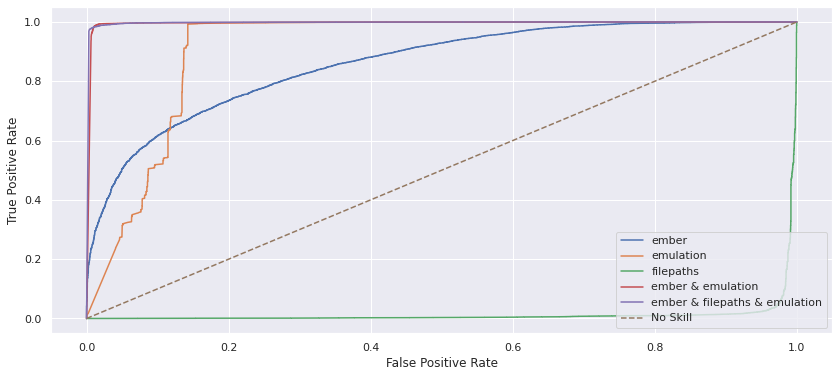

In [6]:
pp = evaluate(models, X_vals, y_val)
# plt.xlim([-0.005, 0.04])
# plt.ylim([0.9, 1.01])
plt.legend(loc="lower right")

# Detection rates under different FPR

In [7]:
def get_threshold_from_rate(thresholds, rate_array, rate):
    index = np.where(rate_array >= rate)[0][0]
    return thresholds[index]

def get_value_from_threshold(values, thresholds, threshold):
    try:
        thr_index = np.where(thresholds <= threshold)[0][0]
    except IndexError:
        thr_index = 0
    return values[thr_index]

def get_fpr_fnr_dicts(models, Xs, y):
    probs = {}
    for model in models:
        if model in ["filepaths", "emulation", "ember"]:
            # TODO: -- .classify_representations() passes 128 > 1 & returns logits, need softmax()
            probs[model] = get_module_probs(model, models, Xs)
        else: # late fusion
            probs[model] = models[model].predict_proba(Xs[model])[:,1]

    fprs, fnrs, tprs, thresholds_roc, thresholds_det = {},{},{},{},{}

    for model in probs:
        fprs[model], tprs[model], thresholds_roc[model] = roc_curve(y, probs[model])
        _, fnrs[model], thresholds_det[model] = det_curve(y, probs[model])
    
    return fprs, fnrs, tprs, thresholds_roc, thresholds_det 

def detection_rates_from_fpr(models, fprs, fnrs, tprs, thresholds_roc, thresholds_det, fpr_rates=list(np.arange(0.0000025, 0.000031, 0.0000025)), savefig=""):
    fixed_fpr_rates = defaultdict(list)
    for fpr_rate in fpr_rates:
        print("===" * 10)
        for model in models:
            threshold = get_threshold_from_rate(thresholds_roc[model], fprs[model], fpr_rate)
            tpr_rate = get_value_from_threshold(tprs[model], thresholds_roc[model], threshold)
            fnr_rate = get_value_from_threshold(fnrs[model], thresholds_det[model][::-1], threshold)
            fnr_rate = 0
            fixed_fpr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold]) 
            print(f"FPR: {fpr_rate*100:>5.3f}% | TPR: {tpr_rate*100:>5.2f}% | FNR: {fnr_rate*100:>5.2f}% | Thr.: {threshold:>5.4f} | {model}")

    # keys for y label
    keys = models.keys()

    # rates for x label
    fpr_rates = [np.array(fixed_fpr_rates[key])[:,0] for key in fixed_fpr_rates][0]
    fpr_rates = [np.round(x*1e5, 2) for x in fpr_rates]

    # rearrange rows, so "all" is last
    tpr_rates = np.vstack([np.array(fixed_fpr_rates[key])[:,1] for key in fixed_fpr_rates])
    tpr_rates = np.round(tpr_rates*100,2)

    fig, ax = plt.subplots(figsize=(13,7))
    ax = sns.heatmap(tpr_rates, ax = ax,
                annot=True, fmt=".2f",
                xticklabels=[x for x in fpr_rates],
                yticklabels=[x.replace(" & ", " &\n") for x in keys])

    ax.set_xlabel(r"False Positive rate, x in $10^{5}$", fontsize=12)
    ax.set_ylabel("Modules", fontsize=12)
    _ = ax.set_title("Detection rate (%) with fixed False Positive rate", fontsize=14)

    if savefig:
        fig.savefig(f"/data/quo.vadis/img/{savefig}.eps",  format='eps', dpi=600, bbox_inches='tight')

def fpr_from_fnr(models, fprs, fnrs, tprs, thresholds_roc, thresholds_det, fnr_rates=[0.0005, 0.001] + list(np.arange(0.0025, 0.02, 0.0025)), savefig=""):
    fixed_fnr_rates = defaultdict(list)
    for fnr_rate in fnr_rates:
        print("===" * 10)
        for model in models:
            threshold = get_threshold_from_rate(thresholds_det[model], fnrs[model], fnr_rate)
            tpr_rate = get_value_from_threshold(tprs[model], thresholds_roc[model], threshold)
            fpr_rate = get_value_from_threshold(fprs[model], thresholds_roc[model], threshold)
            fixed_fnr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold])
            print(f"FPR: {fpr_rate*100:>5.2f}% | TPR: {tpr_rate*100:>5.2f}% | FNR: {fnr_rate*100:>5.2f}% | Thr.: {threshold:>5.4f} | {model}")
    # keys for y label
    keys = models.keys()

    # rates for x label
    fnr_rates = [np.array(fixed_fnr_rates[key])[:,2] for key in fixed_fnr_rates][0]
    fnr_rates = [np.round(x*100, 2) for x in fnr_rates]

    # rearrange rows, so "all" is last
    tpr_rates_fn = np.vstack([np.array(fixed_fnr_rates[key])[:,0] for key in fixed_fnr_rates])
    tpr_rates_fn = np.round(tpr_rates_fn*100,2) 

    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.heatmap(tpr_rates_fn, ax = ax,
                annot=True, fmt=".2f",
                xticklabels=fnr_rates,
                yticklabels=[x.replace(" & ", " &\n") for x in keys],
                cmap="Blues")

    ax.set_xlabel("False Negative rate, %", fontsize=12)
    ax.set_ylabel("Modules", fontsize=12)
    _ = ax.set_title("False Positive rate (%) with fixed False Negative rate", fontsize=14)

    if savefig:
        fig.savefig(f"/data/quo.vadis/img/{savefig}.eps",  format='eps', dpi=600, bbox_inches='tight')


FPR: 0.000% | TPR:  4.26% | FNR:  0.00% | Thr.: 0.8957 | ember
FPR: 0.000% | TPR:  0.11% | FNR:  0.00% | Thr.: 0.5143 | emulation
FPR: 0.000% | TPR:  0.00% | FNR:  0.00% | Thr.: 0.5877 | filepaths
FPR: 0.000% | TPR: 92.77% | FNR:  0.00% | Thr.: 1.0000 | ember & emulation
FPR: 0.000% | TPR: 96.86% | FNR:  0.00% | Thr.: 1.0000 | ember & filepaths & emulation
FPR: 0.025% | TPR:  5.85% | FNR:  0.00% | Thr.: 0.8826 | ember
FPR: 0.025% | TPR:  1.23% | FNR:  0.00% | Thr.: 0.5131 | emulation
FPR: 0.025% | TPR:  0.00% | FNR:  0.00% | Thr.: 0.5600 | filepaths
FPR: 0.025% | TPR: 92.77% | FNR:  0.00% | Thr.: 1.0000 | ember & emulation
FPR: 0.025% | TPR: 96.86% | FNR:  0.00% | Thr.: 1.0000 | ember & filepaths & emulation
FPR: 0.050% | TPR:  6.30% | FNR:  0.00% | Thr.: 0.8792 | ember
FPR: 0.050% | TPR:  1.55% | FNR:  0.00% | Thr.: 0.5131 | emulation
FPR: 0.050% | TPR:  0.00% | FNR:  0.00% | Thr.: 0.5600 | filepaths
FPR: 0.050% | TPR: 92.77% | FNR:  0.00% | Thr.: 1.0000 | ember & emulation
FPR: 0.050

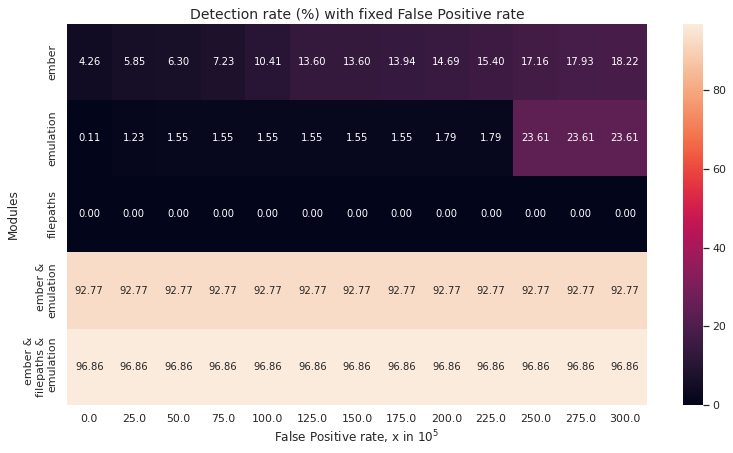

In [8]:
fprs, fnrs, tprs, thresholds_roc, thresholds_det = get_fpr_fnr_dicts(models, X_vals, y_val)
detection_rates_from_fpr(models, fprs, fnrs, tprs, thresholds_roc, thresholds_det, fpr_rates=list(np.arange(2.5e-8, 3.01e-3, 2.5e-4)))

FPR: 92.37% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.2304 | ember
FPR: 54.40% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.4158 | emulation
FPR: 100.00% | TPR: 100.00% | FNR:  0.05% | Thr.: 0.2227 | filepaths
FPR: 46.27% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0000 | ember & emulation
FPR: 35.17% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0000 | ember & filepaths & emulation
FPR: 87.80% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.2618 | ember
FPR: 35.01% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.4254 | emulation
FPR: 100.00% | TPR: 100.00% | FNR:  0.10% | Thr.: 0.2303 | filepaths
FPR: 33.48% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0000 | ember & emulation
FPR: 19.89% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0000 | ember & filepaths & emulation
FPR: 83.22% | TPR: 99.75% | FNR:  0.25% | Thr.: 0.2885 | ember
FPR: 24.41% | TPR: 99.74% | FNR:  0.25% | Thr.: 0.4393 | emulation
FPR: 100.00% | TPR: 100.00% | FNR:  0.25% | Thr.: 0.2381 | filepaths
FPR: 15.92% | TPR: 99.75% | FNR:  0.25% | Thr.: 0.0000 | ember & emulation
FPR:

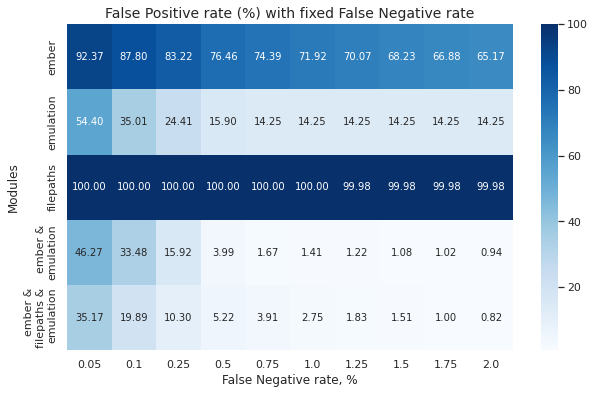

In [9]:
fpr_from_fnr(models, fprs, fnrs, tprs, thresholds_roc, thresholds_det, fnr_rates=[0.0005, 0.001] + list(np.arange(0.0025, 0.02, 0.0025)), savefig="")